# Initialize

In [175]:
%pip install spylls
%pip install pagexml-tools
%pip install tqdm
%pip install pandas matplotlib seaborn scikit-learn graphviz openpyxl

%conda install --channel conda-forge pygraphviz

92011.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


92018.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


92025.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


92031.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 20.0 MB/s eta 0:00:00
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


92038.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn


In [5]:
from pathlib import Path

REPOSITORY_PATH = Path().parent.absolute()
REPOSITORY_PATH


PosixPath('/Users/carstenschnober/LAHTeR/workspace/nautilusocr')

# Read Ground Truth

In [6]:
# TODO: Download and decompress "VOC Ground truths of the trainingset in PAGE xml.7z" from https://zenodo.org/record/6414086


GROUND_TRUTH_PATH = REPOSITORY_PATH / "VOC Ground truths of the trainingset in PAGE xml"
assert (
    GROUND_TRUTH_PATH.is_dir()
), f"Directory containing ground truth not found at {GROUND_TRUTH_PATH.absolute()}"


GROUND_TRUTH_FILES = list(GROUND_TRUTH_PATH.glob("*.xml"))
assert len(GROUND_TRUTH_FILES) == 4735


In [7]:
from pagexml.parser import parse_pagexml_file
from tqdm import tqdm

pagexml_files = [parse_pagexml_file(file) for file in tqdm(GROUND_TRUTH_FILES)]


100%|██████████| 4735/4735 [02:16<00:00, 34.68it/s]


# General Functions

In [147]:
import logging
from typing import List


HYPHENS = {"-", "⸗", "="}


def get_tokens(text) -> List[str]:
    """Copied from features_epr.py"""
    if pd.isna(text):
        logging.warning("No text given.")
        return []
    tokens = list()

    new_token = ""
    for c in text:
        if c == " " and len(new_token) > 0:
            tokens.append(new_token)
            new_token = ""
        elif c == "\n" and len(new_token) > 0:
            if new_token[-1] in HYPHENS:
                new_token = new_token[:-1]
            else:
                tokens.append(new_token)
                new_token = ""
        else:
            new_token += c
    if len(new_token) > 0:
        tokens.append(new_token)

    for i, token in enumerate(tokens):
        if not token[-1].isalpha():
            tokens[i] = token[:-1]
        if not token[0].isalpha():
            tokens[i] = token[1:]

    return tokens


# Dictionary Lookup

## Hunspell

In [9]:
LANGUAGE = "nl"

HUNSPELL_DICT_PATH = REPOSITORY_PATH / "dicts"
assert HUNSPELL_DICT_PATH.is_dir()

SUFFIXES = [".aff", ".dic"]

assert HUNSPELL_DICT_PATH.is_dir()

assert all(
    (HUNSPELL_DICT_PATH / Path(LANGUAGE).with_suffix(suffix)).is_file()
    for suffix in [".aff", ".dic"]
)



In [10]:
from spylls.hunspell import Dictionary

hunspell = Dictionary.from_files(str(HUNSPELL_DICT_PATH / Path(LANGUAGE)))


In [11]:
from typing import List


def get_dict_score(tokens: List[str]):
    if any(len(token) > 0 for token in tokens):
        matched_count = 0
        total_count = 0

        for token in tokens:
            total_count += len(token)

            # TODO: lowercase token?
            matched_count += hunspell.lookup(token) * len(token)

        return matched_count / total_count
    else:
        return 0.0



In [12]:
tokens = ["Dit", "is", "een", "text"]

get_dict_score(tokens)


0.6666666666666666

## Ground Truth Dictionary

In [13]:
from pagexml.parser import parse_pagexml_file
from tqdm import tqdm
import random

words = set()

for pagexml in tqdm(pagexml_files):
    for line in pagexml.get_lines():
        if line.text is not None:
            words.update(get_tokens(line.text))

random.sample(words, 10)


100%|██████████| 4735/4735 [00:00<00:00, 5390.38it/s]
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_99036/3298027077.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(words, 10)


['vaetjes',
 'onveranderlijke',
 'versoecke',
 'gewortelt',
 'mitsg=rs',
 'Mallabaer',
 'Climp',
 'ECompag',
 'voorn.',
 'gorontaalse']

In [14]:
def get_dict_score_gt(tokens):
    if any(len(token) > 0 for token in tokens):
        matched_count = 0
        total_count = 0

        for token in tokens:
            total_count += len(token)

            # TODO: lowercase token?
            matched_count += (token in words) * len(token)

        return matched_count / total_count
    else:
        return 0.0


# Train Tri-Gram Model

## Functions

In [15]:
from typing import List


NGRAM_LENGTH = 3


def get_ngrams(tokens) -> List[str]:
    """Copied, adapted from features_epr.py"""

    n_grams = list()
    for token in tokens:
        token_list = list(token)
        for i in range(0, len(token_list)):
            if not token[i].isalpha():
                token_list[i] = " "
        modified_token = "".join(token_list)
        splits = modified_token.split(" ")
        for split in splits:
            if split != "":
                for i in range(0, len(split) - NGRAM_LENGTH + 1):
                    n_grams.append(split[i : i + NGRAM_LENGTH].lower())
    return n_grams


In [16]:
def get_ngram_score(ngrams, lang_ngrams) -> float:
    """Copied from features_epr.py"""
    # TODO: this is very slow
    # TODO: check if this corresponds to equation 10 in the paper?

    if len(ngrams) == 0:
        return 0

    score = 0
    for ngram in ngrams:
        for i in range(0, len(lang_ngrams)):
            if ngram == lang_ngrams[i]:
                score += 1 - (1 / len(lang_ngrams) * i)
                break

    score = score / len(ngrams)
    return score


## Generate Model

In [17]:
from collections import Counter

from tqdm import tqdm


lang_trigrams = list()

for file in tqdm(pagexml_files, unit="file"):
    for line in pagexml.get_lines():
        tokens = get_tokens(line.text) if line.text else []
        lang_trigrams.extend(get_ngrams(tokens))

print(f"Total n-grams: {len(lang_trigrams)}")
print(f"Distinct n-grams: {len(set(lang_trigrams))}")
print(f"Most common n-grams: ")

Counter(lang_trigrams).most_common(10)


100%|██████████| 4735/4735 [00:02<00:00, 1915.58file/s]


Total n-grams: 2864675
Distinct n-grams: 312
Most common n-grams: 


[('ver', 56820),
 ('den', 52085),
 ('oor', 42615),
 ('ers', 37880),
 ('gen', 33145),
 ('nde', 33145),
 ('rde', 33145),
 ('der', 33145),
 ('voo', 28410),
 ('aar', 28410)]

In [18]:
import os

os.linesep.join([line.text for line in pagexml.get_lines()])


"386\nden 15: Meij 1782.\nDe koning vervolgens te kennen hebbende ge\n„geven hoe node het den Limbotters voorgekomen\nis wegens de van hen gevergde verhuizing\nnaar hun oude woonplaats Limbotto veront„\n„rust te worden: wierd goedgevonden en verstaan\nte repliceeren dat die verhuizing als nuttig\nvoor de Comp:e en naar het oordeel deezer Regee„\n„ring ook nuttig voor de Limbotters zelven\nalleen voorgeslagen en nimmer volstrekt\nop hen begeerd is; dat de Limbotters geen\nzin hebbende in de opbrake van Quandang\nals dan ook behoorden te zorgen dat de ge„\n„bouwen waar onder Comp:s dienaren moeten\nhuisvesten en hare effecten bewaard worden\nweder uit den vervallen staat waarinne men\nverneemd dat geraakt zijn, getrokken wierden\nen altoos 's Comp:s belangens in dien ooird moes„\nten in het oog houden welk laatste niet wel\nanders geschieden kan dan door eene vermeer„\n„derde goud Leverantie.\n/:onderstond:) Aldus gedaan en Gereselveerd tot\nTernaten in’t Kasteel Orange dato voorschreven

In [19]:
text = "Dit is eenasd teksthdgfhfgh"

tokens = get_tokens(text)
trigrams = get_ngrams(tokens)

get_ngram_score(trigrams, lang_trigrams)


0.1874795570178118

In [20]:
scores = Counter()
file_trigrams = list()

for line in pagexml.get_lines():
    text = line.text
    tokens = get_tokens(text)
    line_trigrams = get_ngrams(tokens)
    scores[text] = get_ngram_score(line_trigrams, lang_trigrams)

    file_trigrams.extend(line_trigrams)

scores.most_common()



[('den 15: Meij 1782.', 0.9999996509202616),
 ('De koning vervolgens te kennen hebbende ge', 0.9999952874235297),
 ('hebbende', 0.9999924947856215),
 ('„geven hoe node het den Limbotters voorgekomen', 0.9999875308717395),
 ('is wegens de van hen gevergde verhuizing', 0.9999846230375171),
 ('naar hun oude woonplaats Limbotto veront„', 0.9999767634313173),
 ('„rust te worden: wierd goedgevonden en verstaan', 0.9999710822344593),
 ('op hen begeerd is; dat de Limbotters geen', 0.9999699586083833),
 ('„ring ook nuttig voor de Limbotters zelven', 0.9999696300627472),
 ('te repliceeren dat die verhuizing als nuttig', 0.9999643065967342),
 ('voor de Comp:e en naar het oordeel deezer Regee„', 0.9999619135632636),
 ('als dan ook behoorden te zorgen dat de ge„', 0.9999535258508093),
 ('Limbotters van Quandang is wel', 0.9999528306003298),
 ('voorgeslagen maar geen zin', 0.9999492205340339),
 ('zin hebbende in de opbrake van Quandang', 0.9999475829213657),
 ('alleen voorgeslagen en nimmer volstrek

In [21]:
get_ngram_score(file_trigrams, lang_trigrams)


0.9999367438664196

# Garbage Token Detection

## Functions

In [22]:
EPR_RULE1 = 21
EPR_RULE2 = 3
EPR_RULE3 = 4
EPR_RULE4 = 6
EPR_RULE5 = 8
EPR_RULE9 = 2

VOWELS = "aäàáâǎeéèêëěiîïíìıoöôòóǒuüûùúǔ"


def get_garbage_score(tokens):
    """Copied from features_epr.py"""

    issues = 0

    if len(tokens) == 0:
        return 0

    for token in tokens:

        # rule1
        if len(token) >= EPR_RULE1:
            issues += 1
            continue

        vowel_count = 0
        consonant_count = 0
        lower_case_count = 0
        upper_case_count = 0
        special_char_count = 0
        non_outer_special_chars = set()
        alpha = True
        last_char = None
        repitition_streak = 0
        vowel_streak = 0
        consonant_streak = 0
        go_to_next_token = False
        for i in range(0, len(token)):
            go_to_next_token = False
            char = token[i]

            # collect token info
            if char.isalpha():
                if char.lower() in VOWELS:
                    vowel_count += 1
                    vowel_streak += 1
                    consonant_streak = 0
                else:
                    consonant_count += 1
                    consonant_streak += 1
                    vowel_streak = 0
                if char.isupper():
                    upper_case_count += 1
                else:
                    lower_case_count += 1
            elif char.isalnum():
                alpha = False
                vowel_streak = 0
                consonant_streak = 0
            else:
                special_char_count += 1
                alpha = False
                vowel_streak = 0
                consonant_streak = 0
                if i != 0 and i != len(token) - 1:
                    non_outer_special_chars.add(char)

            # rule 3
            if vowel_streak >= EPR_RULE3:
                issues += 1
                go_to_next_token = True
                break

            # rule 4
            if consonant_streak >= EPR_RULE4:
                issues += 1
                go_to_next_token = True
                break

            if last_char != None and char == last_char:
                repitition_streak += 1

                # rule 2
                if repitition_streak >= EPR_RULE2:
                    issues += 1
                    go_to_next_token = True
                    break
            else:
                repitition_streak = 0
            last_char = char

        if go_to_next_token:
            continue

        if alpha and vowel_count > 0 and consonant_count > 0:
            # rule 5
            if vowel_count * EPR_RULE5 < consonant_count:
                issues += 1
                continue
            # rule 5
            if consonant_count * EPR_RULE5 < vowel_count:
                issues += 1
                continue

        # rule 6
        if lower_case_count > 0 and upper_case_count > lower_case_count:
            issues += 1
            continue

        # rule 7
        if (
            upper_case_count > 0
            and token[0].islower()
            and token[len(token) - 1].islower()
        ):
            issues += 1
            continue

        # rule 8
        regular_chars = len(token) - special_char_count
        if special_char_count >= regular_chars and regular_chars > 0:
            issues += 1
            continue

        # rule 9
        if len(non_outer_special_chars) >= EPR_RULE9:
            issues += 1
            continue

    return issues / len(tokens)



In [23]:
get_garbage_score(get_tokens(text))


0.0

# Publication Year Consideration

In [24]:
# TODO: Fill in correct year range
MIN_YEAR = 1500
MAX_YEAR = 1800


def scale_year(year):
    """Copied from features_epr.py"""

    scaled_year = (year - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    scaled_year = max(min(1.0, scaled_year), 0.0)
    return scaled_year


In [25]:
scale_year(1800)


1.0

# Scoring

In [26]:
DATA_DIR = REPOSITORY_PATH / "data"
assert DATA_DIR.is_dir()


In [27]:
JUDGEMENTS_FILE = DATA_DIR / "limited2 review overview 20220713.csv"
assert JUDGEMENTS_FILE.is_file()


In [28]:
PAGES_DIR = DATA_DIR / "page"
assert PAGES_DIR.is_dir()


## Read Judgements

In [29]:
import pandas as pd

judgements = pd.read_csv(JUDGEMENTS_FILE, index_col=0).rename(
    {"Unnamed: 11": "url"}, axis="columns"
)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN


In [30]:
judgements[["Ranking Kay", "Ranking Maartje"]].corr()


,Ranking Kay,Ranking Maartje
Ranking Kay,1.000000,0.626003
Ranking Maartje,0.626003,1.000000


### Read Error Types

In [ ]:
ERROR_TYPOLOGY_FILE = DATA_DIR / "Error Typology limited2 MH.xlsx"
assert ERROR_TYPOLOGY_FILE.is_file()

In [ ]:
error_types = pd.read_excel(
    ERROR_TYPOLOGY_FILE, usecols=["Filename", "Line No", "Error Code"]
).dropna(subset="Error Code")
error_types


,Filename,Line No,Error Code
0,NL-HaNA_1.04.02_1108_1273,06-01,4.7
1,NL-HaNA_1.04.02_1108_1273,10-38,4.7
2,NL-HaNA_1.04.02_1108_1273,-,4.3
3,NL-HaNA_1.04.02_1636_0070,3-25,3.2
4,NL-HaNA_1.04.02_1636_0070,4-2,4.7
...,...,...,...
143,NL-HaNA_1.04.02_3764_0415,-,3.2
144,NL-HaNA_1.04.02_3970_0021,1-1,4.8
145,NL-HaNA_1.04.02_3970_0021,4-1,2.4.1
146,NL-HaNA_1.04.02_3970_0021,4-1,1.2.2


In [ ]:
error_types["category"] = error_types["Error Code"].apply(lambda x: x.split(".")[0])
error_types

,Filename,Line No,Error Code,category
0,NL-HaNA_1.04.02_1108_1273,06-01,4.7,4
1,NL-HaNA_1.04.02_1108_1273,10-38,4.7,4
2,NL-HaNA_1.04.02_1108_1273,-,4.3,4
3,NL-HaNA_1.04.02_1636_0070,3-25,3.2,3
4,NL-HaNA_1.04.02_1636_0070,4-2,4.7,4
...,...,...,...,...
143,NL-HaNA_1.04.02_3764_0415,-,3.2,3
144,NL-HaNA_1.04.02_3970_0021,1-1,4.8,4
145,NL-HaNA_1.04.02_3970_0021,4-1,2.4.1,2
146,NL-HaNA_1.04.02_3970_0021,4-1,1.2.2,1


In [242]:
judgements = judgements.join(
    error_types.groupby("Filename")
    .value_counts(subset=["category"])
    .unstack(fill_value=0)
    .rename(lambda x: "error_type_" + x, axis="columns"),
    on="Filename",
    lsuffix="error_type_",
)
judgements



,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Read and Process Pages

In [243]:
def tokenize_pagexml(path: Path) -> List[str]:
    parse_pagexml_file(path).text


In [244]:
judgements["path"] = judgements.Filename.apply(lambda f: PAGES_DIR / (f + ".xml"))
assert judgements["path"].apply(Path.is_file).all()
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [245]:
judgements["pagexml"] = judgements.path.apply(parse_pagexml_file)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [246]:
judgements["lines"] = judgements.pagexml.apply(
    lambda pagexml: [line.text for line in pagexml.get_lines() if line.text]
)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
import os

judgements["text"] = judgements.lines.apply(lambda l: os.linesep.join(l))
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
judgements["tokens"] = judgements.text.apply(get_tokens)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [249]:
judgements.iloc[judgements.Som.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
192,193,Gedrukt?!,NaN,0,onbekend,gedrukte pagina,0,0,NL-HaNA_1.04.02_2659_0164,2659,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,94,Goed!,NaN,0,goed,NaN,1,1,NL-HaNA_1.04.02_1851_0707,1851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,188,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_2646_0018,2646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,34,Leeg,NaN,0,goed,leeg; transcriptie die er niet hoort,1,1,NL-HaNA_1.04.02_1306_0327,1306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,480,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_10703_0018,10703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,108,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1967_1068,1967,...,2.0,1.0,1.0,3.0,0.0,2.0,1.0,1.0,3.0,0.0
108,109,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1968_0696,1968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,118,Slecht,Layout,3,slecht,layout,3,6,NL-HaNA_1.04.02_2036_0307,2036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
439,440,Slecht,Regelvolgorde,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_9751_0010,9751,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compute Features

### Dictionary Scores

In [250]:
judgements["dict_score"] = judgements.tokens.apply(get_dict_score)
judgements.iloc[judgements.dict_score.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
474,475,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10633_0002,10633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456,457,Slecht,Regiodetectie/Volgorde,3,goed,leeg,1,4,NL-HaNA_1.04.02_10124_0230,10124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,25,Leeg,NaN,0,goed,leeg; transcriptie die er niet hoort,1,1,NL-HaNA_1.04.02_1269_1040,1269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
434,435,Leeg,NaN,0,medium,leeg; transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9534_0129,9534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,304,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_4071_1018,4071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,93,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1851_0827,1851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,480,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_10703_0018,10703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [251]:
judgements["dict_score_gt"] = judgements.tokens.apply(get_dict_score_gt)
judgements.iloc[judgements.dict_score_gt.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
66,67,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1578_0938,1578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,53,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1443_0212,1443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474,475,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10633_0002,10633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456,457,Slecht,Regiodetectie/Volgorde,3,goed,leeg,1,4,NL-HaNA_1.04.02_10124_0230,10124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,255,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_3389_0782,3389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,93,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1851_0827,1851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,418,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_9342_0377,9342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='dict_score', ylabel='dict_score_gt'>

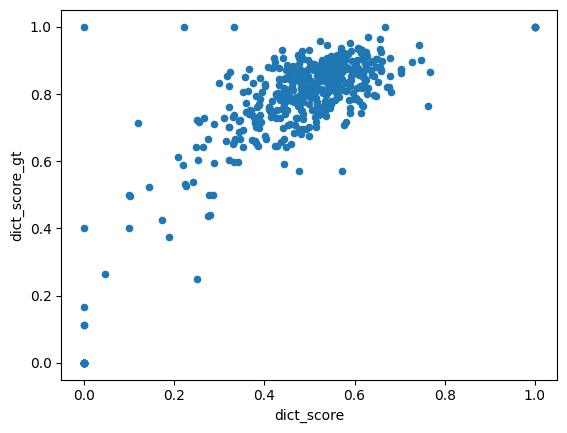

In [252]:
judgements.plot(kind="scatter", x="dict_score", y="dict_score_gt")
# TODO: dot size per text length


### Tri-gram Scores

In [253]:
MAX_N_GRAMS = 1000


judgements["n_gram_score"] = judgements.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams[:MAX_N_GRAMS])
)
judgements.iloc[judgements.n_gram_score.sort_values().index]



,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1error_type_,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
262,263,Slecht,NaN,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_3511_0260,3511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316,317,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_4418_0340,4418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,280,Goed,NaN,1,medium,leeg; transcriptie die er niet hoort,2,3,NL-HaNA_1.04.02_3652_0825,3652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,320,Goed,NaN,1,medium,transcriptie,2,3,NL-HaNA_1.04.02_4444_0535,4444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,112,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1988_1109,1988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336,337,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_7893_0137,7893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,44,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1400_1066,1400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Garbage Token Scores

In [42]:
judgements["garbage_score"] = judgements.tokens.apply(get_garbage_score)
judgements.iloc[judgements.garbage_score.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score
378,379,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8831_0064,8831,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8831_0064.j...,"[Van Cormandel den 18 aug 1719, tot fiscael en...",Van Cormandel den 18 aug 1719\ntot fiscael en\...,"[Van, Cormandel, den, 8, aug, 719, tot, fiscae...",0.534548,0.778284,0.161511,0.000000
85,86,Goed?,Heel veel van andere pagina's,0,slecht,NaN,3,3,NL-HaNA_1.04.02_1785_0028,1785,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1785_0028.j...,[agtb: gunst te continueren over den raad van ...,agtb: gunst te continueren over den raad van j...,"[agtb, gunst, te, continueren, over, den, raad...",0.742475,0.944482,0.192984,0.000000
387,388,Slecht,Tekst en regelherkenning,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_8960_0003,8960,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8960_0003.j...,"[ommis, Ge, Van, e Ven, M, Ce, Ge Ce, V: Cr, C...",ommis\nGe\nVan\ne Ven\nM\nCe\nGe Ce\nV: Cr\nCe...,"[ommis, Ge, Van, e, Ven, M, Ce, Ge, Ce, V, Cr,...",0.404762,0.666667,0.000000,0.000000
131,132,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2155_0281,2155,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2155_0281.j...,"[en palicoll buijten kennisse van, mooren teli...",en palicoll buijten kennisse van\nmooren telic...,"[en, palicoll, buijten, kennisse, van, mooren,...",0.524217,0.849003,0.098145,0.000000
388,389,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8970_1586,8970,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8970_1586.j...,"[Van Ceijlon onder dato 25 Septemb:r 1716, p. ...",Van Ceijlon onder dato 25 Septemb:r 1716\np. ....,"[Van, Ceijlon, onder, dato, 5, Septemb:r, 716,...",0.469930,0.728671,0.054318,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,437,Leeg,NaN,0,medium,leeg; 1 transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9594_0147,9594,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9594_0147.j...,"[6e 8, 9, eeeee, ve ee]",6e 8\n9\neeeee\nve ee,"[e, , , eeeee, ve, ee]",0.100000,0.500000,0.000000,0.166667
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...,"[ee, eve, ee, evee, e, een, 19, eeeee, eeee, e...",0.173448,0.426124,0.048968,0.178344
432,433,Leeg,NaN,0,medium,leeg; transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9467_0563,9467,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9467_0563.j...,"[eeere, eeeee, eve e en]",eeere\neeeee\neve e en,"[eeere, eeeee, eve, e, en]",0.187500,0.375000,0.194800,0.200000
337,338,Slecht,Layout,3,medium,leesvolgorde; ditto,2,5,NL-HaNA_1.04.02_7950_0317,7950,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_7950_0317.j...,"[Baguala, ten overstaan van dies Restherdiers,...","Baguala, ten overstaan van dies Restherdiers, ...","[Baguala, ten, overstaan, van, dies, Restherdi...",0.321101,0.700584,0.036578,0.211009


### Publication Year

Ground truth missing year information

### Column Width

In [380]:
from statistics import mean


def average_line_length(page: pagexml) -> float:
    lengths = [len(line.text) for line in page.get_lines() if line.text is not None]
    return mean(lengths) if lengths else 0



In [383]:
judgements["column_width"] = judgements.pagexml.apply(average_line_length)
judgements

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_2error_type_,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,column_width
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.534884
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,44.872340
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.462687
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.576923
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.225490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.304348
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.382353
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.358491
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.181818


### Words per Text Region

In [436]:
def words_per_region(page: pagexml) -> float:
    words = [region.stats["words"] for region in page.text_regions]
    return mean(words) if words else 0


In [439]:
judgements["words_per_region"] = judgements.pagexml.apply(words_per_region)
judgements

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,column_width,words_per_region
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.534884,114.333333
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,44.872340,120.333333
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.462687,196.000000
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.576923,36.375000
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.225490,2.661017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.304348,122.000000
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.382353,201.000000
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.358491,63.666667
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.181818,53.250000


## Preprocessing and Filtering

In [440]:
judgements["quality"] = np.ceil(judgements.Som / 2).astype(int)
judgements.iloc[judgements.quality.sort_values().index]



,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,column_width,words_per_region
192,193,Gedrukt?!,NaN,0,onbekend,gedrukte pagina,0,0,NL-HaNA_1.04.02_2659_0164,2659,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.288462,31.500000
151,152,goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2314_1588,2314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.176471,41.800000
392,393,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8990_0164,8990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.909091,104.000000
180,181,goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2579_0251,2579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.409091,29.666667
181,182,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2585_0213,2585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.611111,111.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,373,Slecht,Regio-indeling,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_8784_0928,8784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.805556,57.000000
215,216,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_3010_0357,3010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.750000,53.769231
219,220,Slecht,NaN,3,medium,layout; leesvolgorde,2,5,NL-HaNA_1.04.02_3018_0173,3018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.338983,41.909091
394,395,Slecht,Regelherkenning en indeling,3,slecht,leesvolgorde; layout,3,6,NL-HaNA_1.04.02_9009_0451,9009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.266667,93.000000


In [441]:
judgements["Opmerkingen Kay"].unique()


array(['Tekst', nan, 'Leesvolgorde en tekst', 'Leesvolgorde',
       'leesvolgorde', 'Layout', 'Regiovolgorde', 'layout', 'Amanetchan!',
       'tekst', "Heel veel van andere pagina's",
       'Zowel lees als tekst medium', 'Leesvolgorde/Layout',
       'Laout/Leesvolgorde', 'Lay out', 'Baselines', 'Marginalia',
       'Regelvolgorde', 'Layout, tekst', 'Regioherkenning',
       'Herkennen van regels', 'Regio indeling', 'Layout/Regelherkenning',
       'Regioherkenning en volgorde', 'Regelindeling', 'marginalia',
       'Regio-indeling', 'Regioindeling', 'Regelherkenning',
       'Tekst en regelherkenning', 'Regelherkenning en indeling',
       'Regioherkenning/Volgorde', 'Regiovolgorde en herkenning',
       'Regelvolgorde en herkenning',
       "Layout twee pagina's niet goed gedetecteerd", 'Regiodetectie',
       'Regio/Regeldetectie', 'Regiodetectie/Volgorde'], dtype=object)

In [442]:
judgements["Opmerkingen Maartje"].unique()


array([nan, 'leeg', 'leeg; transcriptie die er niet hoort',
       'leesvolgorde (marginalia)', 'layout', 'leesvolgorde',
       'transcriptie', 'layout; leesvolgorde',
       'leesvolgorde + transcriptie',
       'leesvolgorde prima als andere pagina wordt weggedacht',
       'gedrukte pagina', 'layout (marginalia)',
       'leesvolgorde eerste regel alinea ', 'ditto teken', 'marginalia',
       'transcriptie; leesvolgorde', 'transcriptie ',
       'leesvolgorde; transcriptie', 'leesvolgorde; layout',
       'extra pagina er onder gescand', 'leesvolgorde; ditto',
       'leestekens', 'handtekening', 'leeg; transcriptie die er niet is',
       'leeg; 1 transcriptie die er niet is', 'leesvolgorde; cijfers',
       'leeg; 1 transcriptie', 'leestekens, leesvolgorde',
       'moeite met getallen'], dtype=object)

In [443]:
non_empty = judgements.loc[(judgements.text.str.len() > 0) & (judgements.Som > 0)]
agreement = judgements.loc[judgements["Ranking Kay"] == judgements["Ranking Maartje"]]
non_layout = judgements[
    ~(
        (judgements["Opmerkingen Maartje"].str.lower().str.contains("layout"))
        | (judgements["Opmerkingen Kay"].str.lower().str.contains("layout"))
        | (judgements["Opmerkingen Maartje"].str.lower().str.contains("volgorde"))
        | (judgements["Opmerkingen Kay"].str.lower().str.contains("volgorde"))
    )
]


filtered = judgements.iloc[
    non_empty.index.intersection(agreement.index)  # .intersection(non_layout.index)
]
filtered


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_3error_type_,error_type_4error_type_,error_type_5error_type_,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,column_width,words_per_region
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.534884,114.333333
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,44.872340,120.333333
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.462687,196.000000
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.576923,36.375000
5,6,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1111_0725,1111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.869565,68.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,491,Goed,NaN,1,goed,ditto teken,1,2,NL-HaNA_1.04.02_10871_0141,10871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.555556,52.400000
491,492,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_10884_0593,10884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.741935,19.500000
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.304348,122.000000
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.382353,201.000000


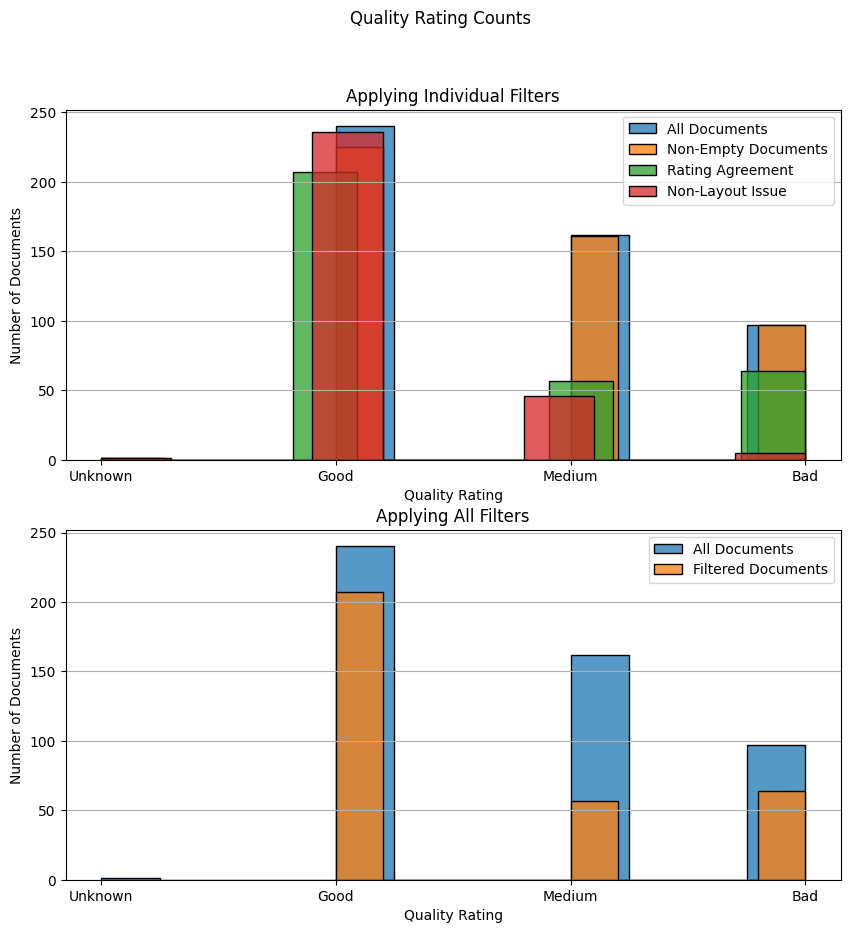

In [444]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10), sharex=False, sharey=True)


fig.suptitle("Quality Rating Counts")

sns.color_palette("tab10")

ax1.set_title("Applying Individual Filters")
sns.histplot(judgements.quality, label="All Documents", ax=ax1)
sns.histplot(non_empty.quality, label="Non-Empty Documents", ax=ax1)
sns.histplot(agreement.quality, label="Rating Agreement", ax=ax1)
sns.histplot(non_layout.quality, label="Non-Layout Issue", ax=ax1)

ax2.set_title("Applying All Filters")
sns.histplot(judgements.quality, label="All Documents", ax=ax2)
sns.histplot(filtered.quality, label="Filtered Documents", ax=ax2)

for ax in (ax1, ax2):
    ax.grid(axis="y")
    ax.set_ylabel("Number of Documents")
    ax.set_xlabel("Quality Rating")
    ax.set_xticks(range(4))
    ax.set_xticklabels(["Unknown", "Good", "Medium", "Bad"])

    ax.legend()



## Plot Features

In [642]:
x_fields = [
    "dict_score",
    "dict_score_gt",
    "n_gram_score",
    "garbage_score",
    # "column_width",
    # "words_per_region",
]

x_fields_normalized = [field + "_normalized" for field in x_fields]

y_field = "quality"


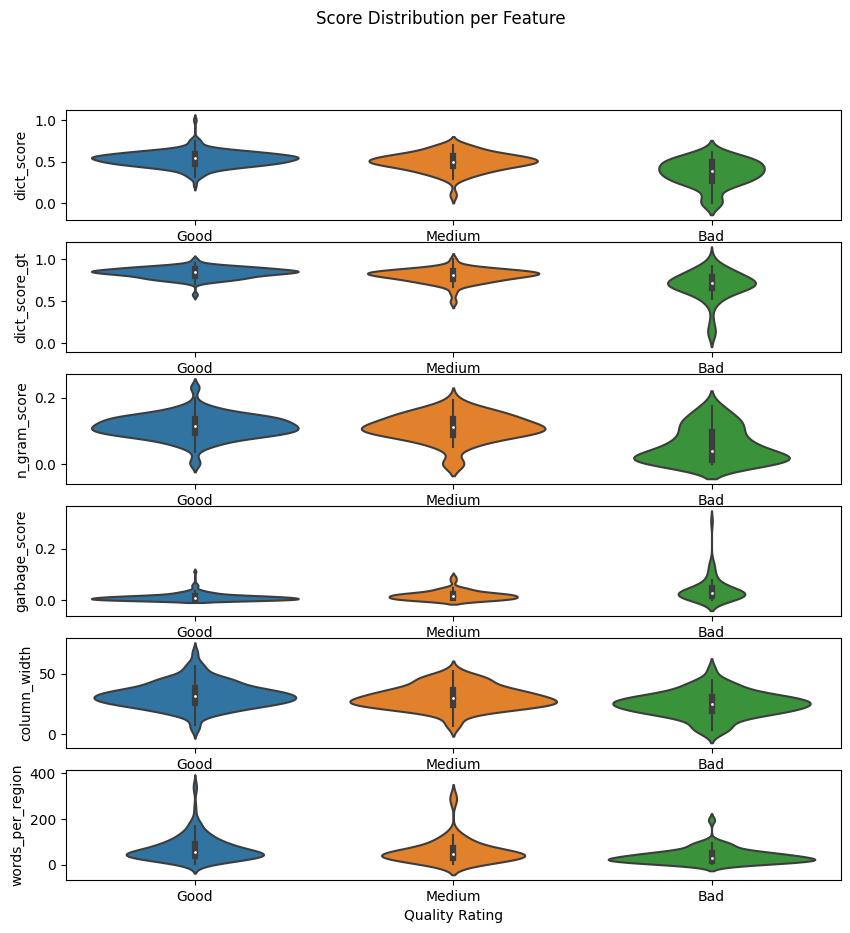

In [446]:
fig, axs = plt.subplots(
    nrows=len(x_fields), figsize=(10, 10), sharex=False, sharey=False
)


fig.suptitle("Score Distribution per Feature")

for ax, column in zip(axs, x_fields):
    sns.violinplot(x=filtered.quality, y=filtered[column], ax=ax)

    ax.set_ylabel(column)
    ax.set_xlabel("Quality Rating")
    ax.set_xticks(range(3))
    ax.set_xticklabels(["Good", "Medium", "Bad"])



## Classify

### Normalize Features

In [447]:
from sklearn import preprocessing

# TODO: refactor for vector operation instead of for loop
for field, normalized_field in zip(x_fields, x_fields_normalized):
    filtered[normalized_field] = preprocessing.minmax_scale(filtered[field])

filtered


/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_99036/1452989403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[normalized_field] = preprocessing.minmax_scale(filtered[field])
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_99036/1452989403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[normalized_field] = preprocessing.minmax_scale(filtered[field])
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_99036/1452989403.py:5: SettingWithCopyWarning: 
A v

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_4,error_type_5,column_width,words_per_region,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,column_width_normalized,words_per_region_normalized
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,47.534884,114.333333,0.378567,0.676325,0.362769,0.009537,0.687584,0.319249
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,3.0,0.0,44.872340,120.333333,0.428164,0.767816,0.424861,0.018122,0.647379,0.336150
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,53.462687,196.000000,0.315423,0.616418,0.337997,0.011145,0.777094,0.549296
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,36.576923,36.375000,0.321451,0.553940,0.288838,0.056203,0.522117,0.099648
5,6,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1111_0725,1111,...,NaN,NaN,44.869565,68.600000,0.418023,0.708285,0.486033,0.028693,0.647337,0.190423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,491,Goed,NaN,1,goed,ditto teken,1,2,NL-HaNA_1.04.02_10871_0141,10871,...,NaN,NaN,34.555556,52.400000,0.601751,0.846143,0.382887,0.087394,0.491594,0.144789
491,492,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_10884_0593,10884,...,NaN,NaN,25.741935,19.500000,0.485714,0.689916,0.234891,0.083873,0.358507,0.052113
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,31.304348,122.000000,0.569307,0.927599,0.519762,0.026812,0.442500,0.340845
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,35.382353,201.000000,0.604352,0.878709,0.752077,0.000000,0.504079,0.563380


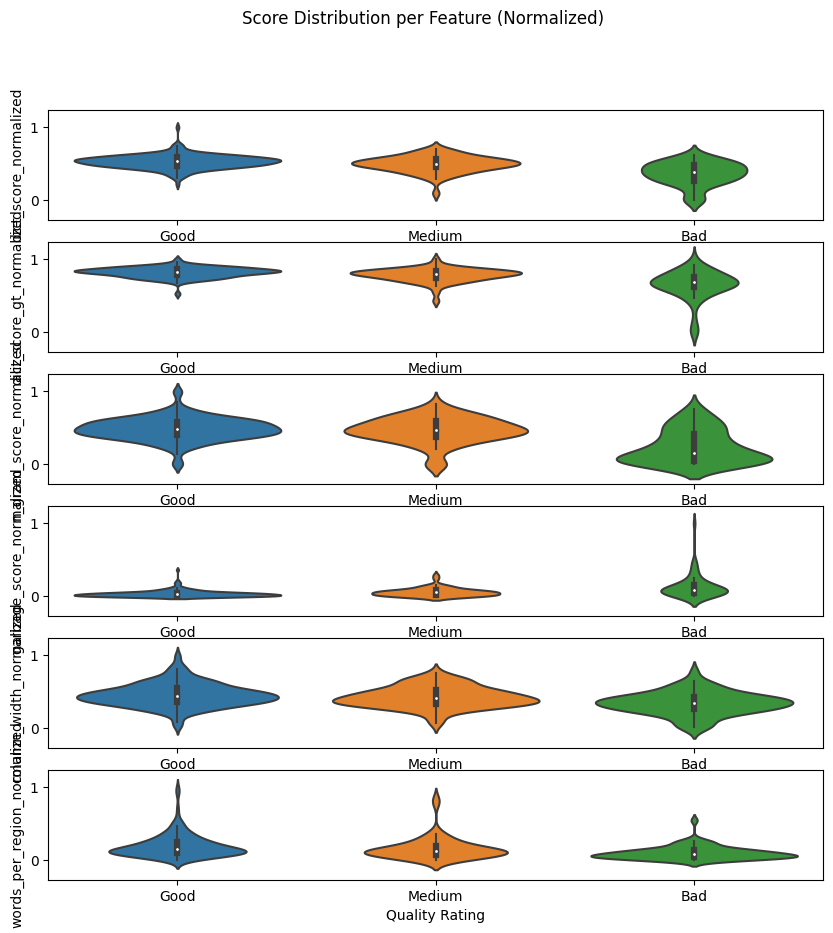

In [448]:
fig, axs = plt.subplots(
    nrows=len(x_fields_normalized), figsize=(10, 10), sharex=False, sharey=True
)

fig.suptitle("Score Distribution per Feature (Normalized)")

for ax, column in zip(axs, x_fields_normalized):
    sns.violinplot(x=filtered.quality, y=filtered[column], ax=ax)

    ax.set_ylabel(column)
    ax.set_xlabel("Quality Rating")
    ax.set_xticks(range(3))
    ax.set_xticklabels(["Good", "Medium", "Bad"])


In [449]:
X = filtered[x_fields_normalized]
y = filtered[y_field]


### Feature Selection

In [496]:
x_fields, X.to_numpy()

(['dict_score',
  'dict_score_gt',
  'n_gram_score',
  'garbage_score',
  'column_width',
  'words_per_region'],
 array([[0.37856727, 0.67632499, 0.36276861, 0.00953652, 0.68758376,
         0.31924883],
        [0.4281642 , 0.76781642, 0.42486112, 0.01812204, 0.64737895,
         0.33615023],
        [0.31542289, 0.61641791, 0.3379968 , 0.0111449 , 0.7770945 ,
         0.54929577],
        ...,
        [0.56930693, 0.92759901, 0.51976236, 0.02681171, 0.44250017,
         0.34084507],
        [0.60435213, 0.8787092 , 0.75207714, 0.        , 0.50407867,
         0.56338028],
        [0.55721925, 0.79545455, 0.74269506, 0.04607082, 0.50105057,
         0.1471831 ]]))

In [523]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

model = SelectKBest(f_classif, k=3)
model.fit_transform(X, y)

{feature: p for feature, p in zip(X.columns, model.pvalues_)}



{'dict_score_normalized': 5.210712381358748e-21,
 'dict_score_gt_normalized': 6.425184263507006e-23,
 'n_gram_score_normalized': 8.42668735542722e-20,
 'garbage_score_normalized': 1.6048204856146441e-13,
 'column_width_normalized': 4.338918991836992e-06,
 'words_per_region_normalized': 4.562826616138667e-05}

In [527]:
from sklearn.feature_selection import SelectFwe
from sklearn.feature_selection import f_classif

model = SelectFwe(f_classif)
model.fit_transform(X, y)
{feature: p for feature, p in zip(X.columns, model.pvalues_)}


{'dict_score_normalized': 5.210712381358748e-21,
 'dict_score_gt_normalized': 6.425184263507006e-23,
 'n_gram_score_normalized': 8.42668735542722e-20,
 'garbage_score_normalized': 1.6048204856146441e-13,
 'column_width_normalized': 4.338918991836992e-06,
 'words_per_region_normalized': 4.562826616138667e-05}

In [516]:
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import chi2

model = SelectFdr()
model.fit_transform(X, y)
model.pvalues_



array([5.21071238e-21, 6.42518426e-23, 8.42668736e-20, 1.60482049e-13,
       4.33891899e-06, 4.56282662e-05])

### KNN

In [450]:
from sklearn.neighbors import KNeighborsClassifier


n = 5

knn_classifier = KNeighborsClassifier(n_neighbors=n)


In [451]:
from sklearn import model_selection

scores = model_selection.cross_val_score(knn_classifier, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)



0.72 accuracy with a standard deviation of 0.03


In [452]:
column = "prediction_knn"

filtered[column] = model_selection.cross_val_predict(knn_classifier, X, y)


/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_99036/1330561670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(knn_classifier, X, y)


In [453]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}" )

F1 Score for bad quality pages with 'prediction_knn': 0.7018


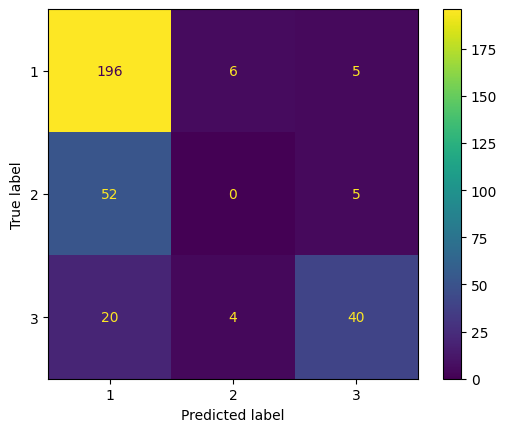

In [454]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(filtered[y_field], filtered[column])


In [455]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.3757292399354545

### Decision Tree

In [456]:
from sklearn import tree

max_depth = 3

decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth)


In [457]:
from sklearn import model_selection

scores = model_selection.cross_val_score(decision_tree, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)



0.67 accuracy with a standard deviation of 0.05


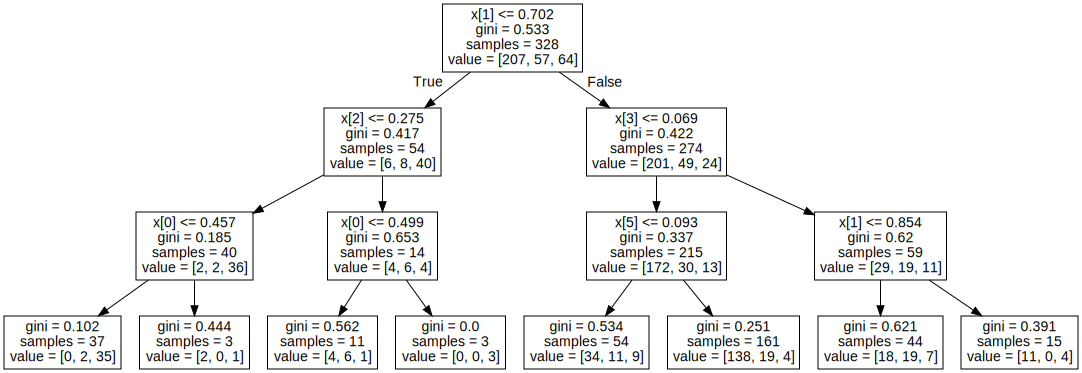

In [458]:
import graphviz
from sklearn.model_selection import train_test_split

decision_tree.fit(X, y)

dot_data = tree.export_graphviz(decision_tree, out_file=None)
graph = graphviz.Source(dot_data)
graph


### Random Forest

In [459]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(max_depth=max_depth)


In [460]:
from sklearn import model_selection

scores = model_selection.cross_val_score(random_forest, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)



0.73 accuracy with a standard deviation of 0.02


In [461]:
column = "prediction_random_forest"

filtered[column] = model_selection.cross_val_predict(random_forest, X, y)



/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_99036/1220456777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(random_forest, X, y)


In [462]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_random_forest': 0.6842


In [463]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.3926960074912743

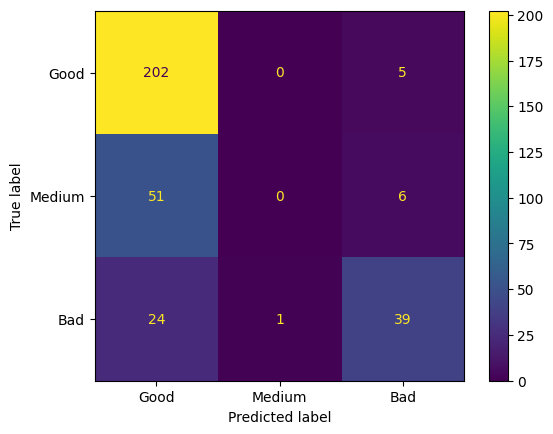

In [464]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(
    filtered[y_field], filtered[column], display_labels=["Good", "Medium", "Bad"]
)


### SVM

In [465]:
from sklearn import svm

svm_classifier = svm.SVC()


In [466]:
from sklearn import model_selection

scores = model_selection.cross_val_score(svm_classifier, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)


0.73 accuracy with a standard deviation of 0.02


In [467]:
column = "prediction_svm"

filtered[column] = model_selection.cross_val_predict(svm_classifier, X, y)



/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_99036/1025515477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(svm_classifier, X, y)


In [468]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_svm': 0.6909


In [469]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.38321877836856444

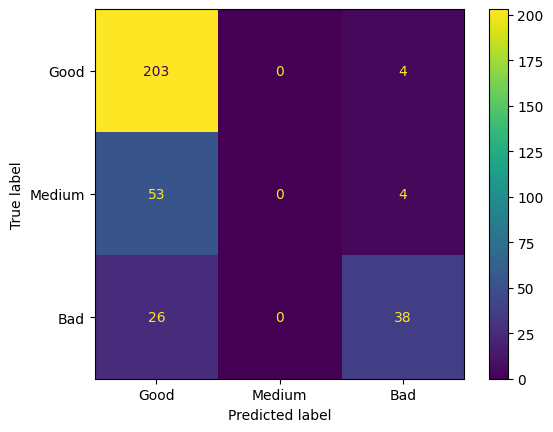

In [470]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(
    filtered[y_field], filtered[column], display_labels=["Good", "Medium", "Bad"]
)


### Multi-layer Perceptron

In [471]:
from sklearn import neural_network

nn = neural_network.MLPClassifier(
    hidden_layer_sizes=(32, 16,), learning_rate="adaptive", max_iter=400
)


In [472]:
scores = model_selection.cross_val_score(nn, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) 

0.73 accuracy with a standard deviation of 0.01


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [473]:
column = "prediction_nn"

filtered[column] = model_selection.cross_val_predict(nn, X, y)



/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_99036/2390862440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(nn, X, y)


In [474]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.40689655172413797

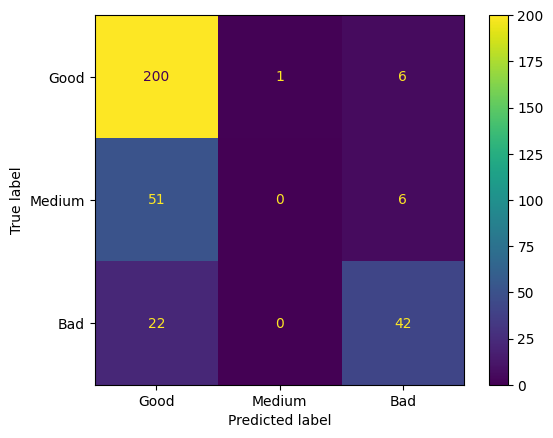

In [475]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(
    filtered[y_field], filtered[column], display_labels=["Good", "Medium", "Bad"]
)


In [476]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_nn': 0.7119


### Analysis

In [477]:
filtered.loc[(filtered.prediction_nn == 1) & (filtered[y_field] == 3)]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,column_width_normalized,words_per_region_normalized,prediction_knn,prediction_random_forest,prediction_svm,prediction_nn
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,0.315423,0.616418,0.337997,0.011145,0.777094,0.549296,1,2,1,1
117,118,Slecht,Layout,3,slecht,layout,3,6,NL-HaNA_1.04.02_2036_0307,2036,...,0.582701,0.861722,0.676602,0.020573,0.210798,0.053873,1,1,1,1
171,172,Slecht,Leesvolgorde,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_2438_1347,2438,...,0.552388,0.818781,0.744364,0.021103,0.382862,0.060161,2,1,1,1
204,205,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_2778_0747,2778,...,0.514925,0.871269,0.331248,0.229783,0.401509,0.133521,1,1,1,1
215,216,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_3010_0357,3010,...,0.432035,0.861834,0.266161,0.177824,0.539831,0.148646,1,1,1,1
272,273,Slecht,NaN,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_3580_0688,3580,...,0.509982,0.801270,0.303578,0.073968,0.378092,0.091784,1,1,1,1
293,294,Slecht,Layout,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_3915_0293,3915,...,0.531292,0.733855,0.530298,0.077727,0.506524,0.106826,1,1,1,1
307,308,Slecht,"Layout, tekst",3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_4313_0120,4313,...,0.500000,0.663247,0.663428,0.061951,0.392763,0.162754,1,1,1,1
323,324,Slecht,Layout,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_4448_0474,4448,...,0.473797,0.760561,0.417459,0.047636,0.381818,0.049936,2,1,1,1
324,325,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_4449_0680,4449,...,0.368962,0.722508,0.496785,0.000000,0.314780,0.046714,1,1,1,1


In [532]:
filtered.loc[(filtered.prediction_nn == 3) & (filtered.quality == 1)][
    ["Filename", "tokens", "text"]
]



,Filename,tokens,text
32,NL-HaNA_1.04.02_1302_0976,"[de, posten, raackende, uEE, ende, dit, Compto...",de posten raackende uEE ende dit Comptoir sull...
163,NL-HaNA_1.04.02_2413_0460,"[Van, Ceijlon, onder, dato, 9:', Ianuarij, 737...",Van Ceijlon onder dato 19:' Ianuarij 1737.\nal...
247,NL-HaNA_1.04.02_3289_0093,"[Aan, Deen, wel, Edelen, Gestr, Heer, Pieter, ...",Aan Deen wel Edelen Gestr: Heer\nPieter Hokste...
254,NL-HaNA_1.04.02_3389_0782,"[ee, en, teene]",ee en\nteene
291,NL-HaNA_1.04.02_3884_0332,"[nagezien, Pompeu]",nagezien\nPompeu:
433,NL-HaNA_1.04.02_9496_0630,"[Nagezien, E, W„m, Louis, Een, Berigt, van, de...",Nagezien\nE„ W„m Louis\nEen Berigt van de Comm...


In [533]:
filtered.loc[(filtered.prediction_nn == 1) & (filtered.quality == 3)][
    ["Filename", "tokens", "text"]
]

,Filename,tokens,text
2,NL-HaNA_1.04.02_1110_0301,"[eersdat, naer, alle, apparentie, met, des, co...",eersdat naer alle apparentie met des comp=es s...
117,NL-HaNA_1.04.02_2036_0307,"[uytslag, van, saken, tot, tyd, en, inslateur,...",uytslag van saken tot tyd en\ninslateur\nS —\n...
171,NL-HaNA_1.04.02_2438_1347,"[Van, Riam, onder, dato, 11, antw:t, eeree, Om...",Van Riam onder dato 311\nantw:t\n--\neeree\nOm...
204,NL-HaNA_1.04.02_2778_0747,"[Van, Banda, onder, dato, , Jbr, A„j, 751, boe...",Van Banda onder dato 8 Jbr A„j 1751\nboekhoude...
215,NL-HaNA_1.04.02_3010_0357,"[64.—, , ., ., Packen, Per, Transport, met, P,...",164.— „ 2. -. Packen Per Transport met P o/ 15...
272,NL-HaNA_1.04.02_3580_0688,"[Nagezie, e, ere, i, J„r, V„r, Ole, Lasten, in...",Nagezie\ne ere\ni\nJ„r V„r Ole\nLasten in dit ...
293,NL-HaNA_1.04.02_3915_0293,"[boven, hunne, waarde, zijn, uijtgegeeven, van...",boven hunne waarde zijn uijtgegeeven van uwelE...
307,NL-HaNA_1.04.02_4313_0120,"[1., 0, En, met, erst, op, het, hem, van, zyne...",11. 10 En met erst op het hem van zynen Broede...
323,NL-HaNA_1.04.02_4448_0474,"[566, a, 577, dito, missive, als, vooren, in, ...",1566 a 1577 dito missive als vooren in dato 11...
324,NL-HaNA_1.04.02_4449_0680,"[93, 939, 90, a, 59, , 62, 63, a, 69, 65, a, 6...",993 1939\n990 a\n959 „ 962\n963 a 469\n965 a 5...


In [424]:
filtered.loc[filtered.prediction_nn != filtered.prediction_knn][
    [y_field]
    + ["prediction_nn", "prediction_knn", "text", "tokens", "Filename"]
    + x_fields_normalized
]



,quality,prediction_nn,prediction_knn,text,tokens,Filename,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,column_width_normalized
67,1,1,2,Van Ternaten onder dato 4„e augustij a=o 1697....,"[Van, Ternaten, onder, dato, „e, augustij, a=o...",NL-HaNA_1.04.02_1595_0689,0.542047,0.880319,0.550823,0.060295,0.680668
71,1,1,2,Respect en onderdanigh=t d’ Eere van over zeij...,"[Respect, en, onderdanigh=t, d, Eere, van, ove...",NL-HaNA_1.04.02_1636_0070,0.465578,0.841130,0.483505,0.026648,0.471561
72,3,3,2,cen\nd.o\nordinaire rantsaeme 1702 ƒ 10972. 14...,"[cen, d.o, ordinaire, rantsaeme, 702, ƒ, 0972....",NL-HaNA_1.04.02_1672_0566,0.418642,0.699960,0.222069,0.067712,0.283013
77,1,1,2,worden ondertussen sullen wij bij den\nanderen...,"[worden, ondertussen, sullen, wij, bij, den, a...",NL-HaNA_1.04.02_1724_0700,0.426667,0.775000,0.422406,0.069106,0.307494
94,1,1,2,Van Versien onder dato 15' Junij A:o 1714.\ndi...,"[Van, Versien, onder, dato, 5', Junij, A:o, 71...",NL-HaNA_1.04.02_1856_1503,0.489186,0.771756,0.457554,0.056641,0.307596
108,3,1,3,1:,[:],NL-HaNA_1.04.02_1968_0696,0.000000,1.000000,0.000000,0.000000,0.000000
150,1,1,2,Van Ternaten onder dato 15:' Iulij 1734 —\ndoe...,"[Van, Ternaten, onder, dato, 5:', Iulij, 734, ...",NL-HaNA_1.04.02_2313_1022,0.465241,0.747326,0.491206,0.119672,0.354434
204,3,3,1,Van Banda onder dato 8 Jbr A„j 1751\nboekhoude...,"[Van, Banda, onder, dato, , Jbr, A„j, 751, boe...",NL-HaNA_1.04.02_2778_0747,0.514925,0.871269,0.331248,0.229783,0.401509
282,3,1,3,1782 ult=o meij op Ternaten ontfangen 500 15„ ...,"[782, ult=o, meij, op, Ternaten, ontfangen, 00...",NL-HaNA_1.04.02_3764_0415,0.486046,0.709210,0.297964,0.084474,0.323765
300,2,1,3,Maijreie\ne Com\n4 sche en e .\n„ a:o\nvande\n...,"[Maijreie, e, Com, , sche, en, e, , , a:o, van...",NL-HaNA_1.04.02_4002_0204,0.486822,0.747093,0.212912,0.023876,0.326712


In [425]:
error_type_columns = ["error_type_" + str(i) for i in range(1, 6)]
prediction_columns = [
    column for column in filtered.columns if column.startswith("prediction")
]

filtered.loc[
    filtered[error_type_columns].notna().all(axis="columns")
    & (filtered.quality != filtered.prediction_nn)
][error_type_columns + prediction_columns + ["quality"]]



,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,prediction_knn,prediction_random_forest,prediction_svm,prediction_nn,quality
170,13.0,0.0,1.0,2.0,0.0,3,3,3,3,2
220,1.0,1.0,2.0,3.0,0.0,1,1,1,1,2
281,5.0,2.0,3.0,4.0,0.0,1,1,1,1,2
282,3.0,2.0,7.0,1.0,0.0,3,1,1,1,3
294,1.0,1.0,1.0,1.0,0.0,1,1,1,1,2


# Test on HTR data

In [291]:
classifier = nn.fit(X, y)

/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [84]:
RESULTS_FILE = DATA_DIR / "allresults.tar.bz2"
assert RESULTS_FILE.is_file()

### Random Lines

In [85]:
import tarfile
import random

ENCODING = "UTF-8"

TOTAL_FILES = 6873
LINES_PER_FILE = 10000

OUTPUT_LINES = 10000

total_lines = TOTAL_FILES * LINES_PER_FILE

#line_numbers = set(random.choices(range(total_lines), k=OUTPUT_LINES))
#file_numbers = {int(line / LINES_PER_FILE) for line in line_numbers}

random_threshold = 1-(OUTPUT_LINES / total_lines)

random_threshold

0.9998545031281827

In [142]:
from tqdm import tqdm

lines = []

with tqdm(total=OUTPUT_LINES, unit="line", desc="Reading") as pbar, tarfile.open(
    RESULTS_FILE, "r:bz2"
) as tar:
    for tarinfo in tar:
        if len(lines) >= OUTPUT_LINES:
            break
        for line in tar.extractfile(tarinfo):
            if len(lines) >= OUTPUT_LINES:
                break
            if random.random() > random_threshold:
                lines.append(line.decode(ENCODING))
                pbar.update()


lines


Reading: 100%|██████████| 10000/10000 [04:51<00:00, 34.35line/s]


['/data/globalise/1.04.02/10002/imagesnippets/NL-HaNA_1.04.02_10002_0181/NL-HaNA_1.04.02_10002_0181.xml-f2944cca-be21-4961-8b6c-02e66f58587f.png\t0.27434635\tter hand steleten, met verzoek om\n',
 '/data/globalise/1.04.02/10002/imagesnippets/NL-HaNA_1.04.02_10002_0097/NL-HaNA_1.04.02_10002_0097.xml-line_4b5213e6-feaa-4349-9319-d9ab054df789.png\t0.09957577\tmij ni verzeekert te kunnen houden van de de\n',
 '/data/globalise/1.04.02/10003/imagesnippets/NL-HaNA_1.04.02_10003_0246/NL-HaNA_1.04.02_10003_0246.xml-line_77f39c98-3d05-4be5-8af0-235333884034.png\t0.18038996\tvoldaan, ter schadeloos stelling van de„\n',
 '/data/globalise/1.04.02/10003/imagesnippets/NL-HaNA_1.04.02_10003_0282/NL-HaNA_1.04.02_10003_0282.xml-line_7a40d1c5-7c66-49cd-80e7-6c151b7bfbea.png\t0.22229095\t„ve papieren in een apparte bande\n',
 '/data/globalise/1.04.02/10003/imagesnippets/NL-HaNA_1.04.02_10003_0362/NL-HaNA_1.04.02_10003_0362.xml-a54eb8c1-0c00-48f0-a2b3-ef28be22f91f.png\t0.012168837\thebben overgebragt. . . 

In [145]:
import os
from io import StringIO

results = pd.read_csv(
    StringIO(os.linesep.join(lines)),
    delimiter="\t",
    header=None,
    names=["File", "Score", "text"],
    dtype={"text":str}
)
results


,File,Score,text
0,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.274346,"ter hand steleten, met verzoek om"
1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.099576,mij ni verzeekert te kunnen houden van de de
2,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.180390,"voldaan, ter schadeloos stelling van de„"
3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.222291,„ve papieren in een apparte bande
4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.012169,hebben overgebragt. . . . . . . . . . . . . . ...
...,...,...,...
9995,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.831892,te dragen
9996,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.024515,Sondag 25: wist 'sE: Comp:s hoffgaager te verh...
9997,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.083118,Van Bengale onderdato 3:' maart 1732
9998,/data/globalise/1.04.02/2242/imagesnippets/NL-...,0.596369,van sijnen raad —.


In [148]:
results["tokens"] = results.text.apply(get_tokens)
results

,File,Score,text,tokens
0,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.274346,"ter hand steleten, met verzoek om","[ter, hand, steleten, met, verzoek, om]"
1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.099576,mij ni verzeekert te kunnen houden van de de,"[mij, ni, verzeekert, te, kunnen, houden, van,..."
2,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.180390,"voldaan, ter schadeloos stelling van de„","[voldaan, ter, schadeloos, stelling, van, de]"
3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.222291,„ve papieren in een apparte bande,"[ve, papieren, in, een, apparte, bande]"
4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.012169,hebben overgebragt. . . . . . . . . . . . . . ...,"[hebben, overgebragt, , , , , , , , , , , , , ..."
...,...,...,...,...
9995,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.831892,te dragen,"[te, dragen]"
9996,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.024515,Sondag 25: wist 'sE: Comp:s hoffgaager te verh...,"[Sondag, 5:, wist, sE:, Comp:s, hoffgaager, te..."
9997,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.083118,Van Bengale onderdato 3:' maart 1732,"[Van, Bengale, onderdato, :', maart, 732]"
9998,/data/globalise/1.04.02/2242/imagesnippets/NL-...,0.596369,van sijnen raad —.,"[van, sijnen, raad, .]"


In [149]:
results["dict_score"] = results.tokens.apply(get_dict_score)
results.iloc[results.dict_score.sort_values().index]


,File,Score,text,tokens,dict_score
1592,/data/globalise/1.04.02/1079/imagesnippets/NL-...,0.306423,61„ 6„10,"[1„, „10]",0.0
1751,/data/globalise/1.04.02/1087/imagesnippets/NL-...,0.061643,3,[],0.0
8165,/data/globalise/1.04.02/1889/imagesnippets/NL-...,0.599512,toire Nangasackij,"[toire, Nangasackij]",0.0
1749,/data/globalise/1.04.02/1087/imagesnippets/NL-...,0.310848,7,[],0.0
8167,/data/globalise/1.04.02/1889/imagesnippets/NL-...,0.000081,.. „ —: 3:— —: 3: 52: —: 3:— —: 3: -. . . . .,"[., , :, :—, :, :, 2:, :, :—, :, :, ., , , , ]",0.0
...,...,...,...,...,...
4222,/data/globalise/1.04.02/1378/imagesnippets/NL-...,0.924751,te betalen,"[te, betalen]",1.0
4219,/data/globalise/1.04.02/1378/imagesnippets/NL-...,0.393050,tot,[tot],1.0
4214,/data/globalise/1.04.02/1377/imagesnippets/NL-...,0.024071,niets voorgevallen,"[niets, voorgevallen]",1.0
1497,/data/globalise/1.04.02/1072/imagesnippets/NL-...,0.848259,250 last,"[50, last]",1.0


In [150]:
results["dict_score_gt"] = results.tokens.apply(get_dict_score_gt)
results.iloc[results.dict_score_gt.sort_values().index]


,File,Score,text,tokens,dict_score,dict_score_gt
3302,/data/globalise/1.04.02/1264/imagesnippets/NL-...,0.261310,ester,[ester],1.000000,0.0
7136,/data/globalise/1.04.02/1695/imagesnippets/NL-...,0.422274,7,[],0.000000,0.0
7143,/data/globalise/1.04.02/1696/imagesnippets/NL-...,0.407552,oosthuysen,[oosthuysen],0.000000,0.0
7148,/data/globalise/1.04.02/1696/imagesnippets/NL-...,0.061555,NaN,[],0.000000,0.0
1337,/data/globalise/1.04.02/1065/imagesnippets/NL-...,0.099440,9,[],0.000000,0.0
...,...,...,...,...,...,...
6044,/data/globalise/1.04.02/1543/imagesnippets/NL-...,0.280952,med wat somma d' Eijgenaars,"[med, wat, somma, d, Eijgenaars]",0.409091,1.0
1866,/data/globalise/1.04.02/10907/imagesnippets/NL...,0.610259,"weest zijnde, het huijs van","[weest, zijnde, het, huijs, van]",0.772727,1.0
1867,/data/globalise/1.04.02/10908/imagesnippets/NL...,0.024910,secret:s Ten,"[secret:s, Ten]",0.272727,1.0
1859,/data/globalise/1.04.02/10903/imagesnippets/NL...,0.509112,om zulx s geschild,"[om, zulx, s, geschild]",0.733333,1.0


In [151]:

results["n_gram_score"] = results.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams[:MAX_N_GRAMS])
)
results.iloc[results.n_gram_score.sort_values().index]


,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score
4999,/data/globalise/1.04.02/1457/imagesnippets/NL-...,0.254920,"de copie vande facture, andermaal jegenwoordig...","[de, copie, vande, facture, andermaal, jegenwo...",0.452830,1.0000,0.0
5734,/data/globalise/1.04.02/1517/imagesnippets/NL-...,0.127659,Van Palimbangh onder dato ult=o Aug=o Ao 1692.,"[Van, Palimbangh, onder, dato, ult=o, Aug=o, A...",0.315789,1.0000,0.0
5733,/data/globalise/1.04.02/1517/imagesnippets/NL-...,0.972928,450,[50],1.000000,1.0000,0.0
5731,/data/globalise/1.04.02/1517/imagesnippets/NL-...,0.363353,9,[],0.000000,0.0000,0.0
5728,/data/globalise/1.04.02/1517/imagesnippets/NL-...,0.168528,"metterdaat, buijden alle veijnsingen off uijtv...","[metterdaat, buijden, alle, veijnsingen, off, ...",0.125000,0.1875,0.0
...,...,...,...,...,...,...,...
812,/data/globalise/1.04.02/10364/imagesnippets/NL...,0.990446,den,[den],1.000000,1.0000,1.0
4682,/data/globalise/1.04.02/1433/imagesnippets/NL-...,0.620061,den:,[den],1.000000,1.0000,1.0
9308,/data/globalise/1.04.02/2108/imagesnippets/NL-...,0.979334,den,[den],1.000000,1.0000,1.0
2422,/data/globalise/1.04.02/1122/imagesnippets/NL-...,0.961961,den,[den],1.000000,1.0000,1.0


In [152]:
results["garbage_score"] = results.tokens.apply(get_garbage_score)
results.iloc[results.garbage_score.sort_values().index]


,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score
0,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.274346,"ter hand steleten, met verzoek om","[ter, hand, steleten, met, verzoek, om]",1.000000,0.703704,0.160167,0.0
6519,/data/globalise/1.04.02/1591/imagesnippets/NL-...,0.008917,p:,[p],1.000000,1.000000,0.000000,0.0
6521,/data/globalise/1.04.02/1591/imagesnippets/NL-...,0.904329,1197,[197],1.000000,0.000000,0.000000,0.0
6522,/data/globalise/1.04.02/1591/imagesnippets/NL-...,0.359815,uijt dat noit winst vande lijwaten ge„,"[uijt, dat, noit, winst, vande, lijwaten, ge]",0.322581,1.000000,0.124714,0.0
6523,/data/globalise/1.04.02/1592/imagesnippets/NL-...,0.748693,guinees voor India haar uu toegedeelt,"[guinees, voor, India, haar, uu, toegedeelt]",0.406250,1.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...
7869,/data/globalise/1.04.02/1833/imagesnippets/NL-...,0.920410,16.,[6.],0.000000,1.000000,0.000000,1.0
1320,/data/globalise/1.04.02/10642/imagesnippets/NL...,0.020371,5/0,[/0],0.000000,0.000000,0.000000,1.0
4229,/data/globalise/1.04.02/1378/imagesnippets/NL-...,0.091062,:-:15:-,[-:15:-],0.000000,0.000000,0.000000,1.0
1000,/data/globalise/1.04.02/10455/imagesnippets/NL...,0.104623,1p.,[p.],1.000000,1.000000,0.000000,1.0


In [647]:
from sklearn import preprocessing

# TODO: refactor for vector operation instead of for loop
for field, normalized_field in zip(x_fields, x_fields_normalized):
    results[normalized_field] = preprocessing.minmax_scale(results[field])

results


,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn,Predicted Quality
0,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.274346,"ter hand steleten, met verzoek om","[ter, hand, steleten, met, verzoek, om]",1.000000,0.703704,0.160167,0.000000,1.000000,0.703704,0.160167,0.000000,1,Good
1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.099576,mij ni verzeekert te kunnen houden van de de,"[mij, ni, verzeekert, te, kunnen, houden, van,...",0.666667,0.666667,0.105111,0.000000,0.666667,0.666667,0.105111,0.000000,1,Good
2,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.180390,"voldaan, ter schadeloos stelling van de„","[voldaan, ter, schadeloos, stelling, van, de]",1.000000,1.000000,0.317833,0.000000,1.000000,1.000000,0.317833,0.000000,1,Good
3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.222291,„ve papieren in een apparte bande,"[ve, papieren, in, een, apparte, bande]",0.666667,0.814815,0.135833,0.000000,0.666667,0.814815,0.135833,0.000000,1,Good
4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.012169,hebben overgebragt. . . . . . . . . . . . . . ...,"[hebben, overgebragt, , , , , , , , , , , , , ...",0.272727,1.000000,0.000000,0.083333,0.272727,1.000000,0.000000,0.083333,3,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.831892,te dragen,"[te, dragen]",1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1,Good
9996,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.024515,Sondag 25: wist 'sE: Comp:s hoffgaager te verh...,"[Sondag, 5:, wist, sE:, Comp:s, hoffgaager, te...",0.522727,0.772727,0.097000,0.111111,0.522727,0.772727,0.097000,0.111111,3,Bad
9997,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.083118,Van Bengale onderdato 3:' maart 1732,"[Van, Bengale, onderdato, :', maart, 732]",0.379310,1.000000,0.000000,0.000000,0.379310,1.000000,0.000000,0.000000,1,Good
9998,/data/globalise/1.04.02/2242/imagesnippets/NL-...,0.596369,van sijnen raad —.,"[van, sijnen, raad, .]",0.500000,1.000000,0.236500,0.000000,0.500000,1.000000,0.236500,0.000000,1,Good


In [159]:
results["prediction_nn"] = classifier.predict(results[x_fields_normalized])
results

,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn
0,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.274346,"ter hand steleten, met verzoek om","[ter, hand, steleten, met, verzoek, om]",1.000000,0.703704,0.160167,0.000000,1.000000,0.703704,0.160167,0.000000,1
1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.099576,mij ni verzeekert te kunnen houden van de de,"[mij, ni, verzeekert, te, kunnen, houden, van,...",0.666667,0.666667,0.105111,0.000000,0.666667,0.666667,0.105111,0.000000,1
2,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.180390,"voldaan, ter schadeloos stelling van de„","[voldaan, ter, schadeloos, stelling, van, de]",1.000000,1.000000,0.317833,0.000000,1.000000,1.000000,0.317833,0.000000,1
3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.222291,„ve papieren in een apparte bande,"[ve, papieren, in, een, apparte, bande]",0.666667,0.814815,0.135833,0.000000,0.666667,0.814815,0.135833,0.000000,1
4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.012169,hebben overgebragt. . . . . . . . . . . . . . ...,"[hebben, overgebragt, , , , , , , , , , , , , ...",0.272727,1.000000,0.000000,0.083333,0.272727,1.000000,0.000000,0.083333,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.831892,te dragen,"[te, dragen]",1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1
9996,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.024515,Sondag 25: wist 'sE: Comp:s hoffgaager te verh...,"[Sondag, 5:, wist, sE:, Comp:s, hoffgaager, te...",0.522727,0.772727,0.097000,0.111111,0.522727,0.772727,0.097000,0.111111,3
9997,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.083118,Van Bengale onderdato 3:' maart 1732,"[Van, Bengale, onderdato, :', maart, 732]",0.379310,1.000000,0.000000,0.000000,0.379310,1.000000,0.000000,0.000000,1
9998,/data/globalise/1.04.02/2242/imagesnippets/NL-...,0.596369,van sijnen raad —.,"[van, sijnen, raad, .]",0.500000,1.000000,0.236500,0.000000,0.500000,1.000000,0.236500,0.000000,1


[Text(0, 0, 'Good'), Text(1, 0, 'Bad')]

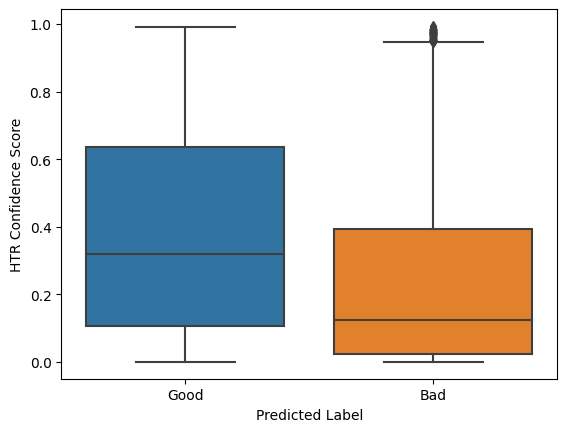

In [534]:
ax = sns.boxplot(x=results["prediction_nn"], y=results["Score"])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("HTR Confidence Score")
ax.set_xticklabels(["Good", "Bad"])



In [541]:
mapper = {1: "Good", 2: "Medium", 3: "Bad"}
results["Predicted Quality"] = results.prediction_nn.apply(lambda x: mapper[x])
results


,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn,Predicted Quality
0,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.274346,"ter hand steleten, met verzoek om","[ter, hand, steleten, met, verzoek, om]",1.000000,0.703704,0.160167,0.000000,1.000000,0.703704,0.160167,0.000000,1,Good
1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.099576,mij ni verzeekert te kunnen houden van de de,"[mij, ni, verzeekert, te, kunnen, houden, van,...",0.666667,0.666667,0.105111,0.000000,0.666667,0.666667,0.105111,0.000000,1,Good
2,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.180390,"voldaan, ter schadeloos stelling van de„","[voldaan, ter, schadeloos, stelling, van, de]",1.000000,1.000000,0.317833,0.000000,1.000000,1.000000,0.317833,0.000000,1,Good
3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.222291,„ve papieren in een apparte bande,"[ve, papieren, in, een, apparte, bande]",0.666667,0.814815,0.135833,0.000000,0.666667,0.814815,0.135833,0.000000,1,Good
4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.012169,hebben overgebragt. . . . . . . . . . . . . . ...,"[hebben, overgebragt, , , , , , , , , , , , , ...",0.272727,1.000000,0.000000,0.083333,0.272727,1.000000,0.000000,0.083333,3,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.831892,te dragen,"[te, dragen]",1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1,Good
9996,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.024515,Sondag 25: wist 'sE: Comp:s hoffgaager te verh...,"[Sondag, 5:, wist, sE:, Comp:s, hoffgaager, te...",0.522727,0.772727,0.097000,0.111111,0.522727,0.772727,0.097000,0.111111,3,Bad
9997,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.083118,Van Bengale onderdato 3:' maart 1732,"[Van, Bengale, onderdato, :', maart, 732]",0.379310,1.000000,0.000000,0.000000,0.379310,1.000000,0.000000,0.000000,1,Good
9998,/data/globalise/1.04.02/2242/imagesnippets/NL-...,0.596369,van sijnen raad —.,"[van, sijnen, raad, .]",0.500000,1.000000,0.236500,0.000000,0.500000,1.000000,0.236500,0.000000,1,Good


In [543]:
OUTPUT_FILE = DATA_DIR / "results_classification.csv"

output_columns = ["File", "Score", "text", "Predicted Quality"]

assert (
    not OUTPUT_FILE.exists()
), f"Output file already exists: '{OUTPUT_FILE.absolute()}'"

results[output_columns].to_csv(OUTPUT_FILE)


### Random Pages

In [587]:
OUTPUT_PAGES = 1000
TOTAL_PAGES = 4726734

random_threshold = 1 - (OUTPUT_PAGES / TOTAL_PAGES)

random_threshold


0.9997884374284655

In [590]:
selected_pages = set()
current_page = None
select = False
lines = []

with tqdm(total=OUTPUT_PAGES, unit="page", desc="Reading") as pbar, tarfile.open(
    RESULTS_FILE, "r:bz2"
) as tar:
    for tarinfo in tar:
        if len(selected_pages) >= OUTPUT_PAGES:
            break
        for line in tar.extractfile(tarinfo):
            if len(selected_pages) >= OUTPUT_PAGES:
                break
            try:
                decoded = line.decode(ENCODING)

                path = Path(decoded.split("\t")[0])
                filename = path.parent.name

                if filename != current_page:
                    logging.debug(f"New page: '{filename}'")
                    current_page = filename
                    select = random.random() > random_threshold
                    if select:
                        logging.info(f"Page selected: '{filename}'")
                        selected_pages.add(filename)
                        pbar.update()
                if select:
                    lines.append(decoded)

            except Exception as e:
                logging.error(
                    f"Failed to parse file '{tarinfo.name}', skipping: {str(e)}"
                )

assert len(selected_pages) == OUTPUT_PAGES
lines


Reading: 100%|██████████| 1000/1000 [26:03<00:00,  1.56s/line]


['/data/globalise/1.04.02/10038/imagesnippets/NL-HaNA_1.04.02_10038_0337/NL-HaNA_1.04.02_10038_0337.xml-line_4b684016-c11b-4224-bb6d-ed3fde373033.png\t0.52019846\tbij derhand tenemen; meen repliceerde\n',
 '/data/globalise/1.04.02/10038/imagesnippets/NL-HaNA_1.04.02_10038_0337/NL-HaNA_1.04.02_10038_0337.xml-bd19377d-b6a9-4068-86e8-c2ef2ad1175f.png\t0.122971244\tschrijven na Colombo en tutuc: —\n',
 '/data/globalise/1.04.02/10038/imagesnippets/NL-HaNA_1.04.02_10038_0337/NL-HaNA_1.04.02_10038_0337.xml-line_3a8a473b-f5bb-4c76-9c9f-cbe95b6d7a62.png\t0.47003198\tverlopen was, om soo Eengewigtige zaak\n',
 '/data/globalise/1.04.02/10038/imagesnippets/NL-HaNA_1.04.02_10038_0337/NL-HaNA_1.04.02_10038_0337.xml-line_4e2080ca-332d-42bd-8464-ccd3dbc2ccb2.png\t0.13632677\tLebbe neijna:/ en verdere moorse\n',
 '/data/globalise/1.04.02/10038/imagesnippets/NL-HaNA_1.04.02_10038_0337/NL-HaNA_1.04.02_10038_0337.xml-a8bf90c2-a407-434a-a715-dc42977af8b0.png\t0.449398\twerden aangeplackt aan depoort\n',
 '

In [630]:
results_pages = pd.read_csv(
    StringIO(os.linesep.join(lines)),
    delimiter="\t",
    header=None,
    names=["File", "Score", "text"],
    dtype={"text": str}
).dropna(subset="text")
results_pages


,File,Score,text
0,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.520198,bij derhand tenemen; meen repliceerde
1,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.122971,schrijven na Colombo en tutuc: —
2,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.470032,"verlopen was, om soo Eengewigtige zaak"
3,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.136327,Lebbe neijna:/ en verdere moorse
4,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.449398,werden aangeplackt aan depoort
...,...,...,...
38582,/data/globalise/1.04.02/9690/imagesnippets/NL-...,0.488792,zijne huis-vrouwe voor gedag„
38583,/data/globalise/1.04.02/9690/imagesnippets/NL-...,0.846104,bui„
38584,/data/globalise/1.04.02/9690/imagesnippets/NL-...,0.565344,2
38585,/data/globalise/1.04.02/9690/imagesnippets/NL-...,0.225247,Vrouw


In [632]:
results_pages["page"] = results_pages.File.apply(lambda x: Path(x).parent.name)
results_pages

,File,Score,text,page
0,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.520198,bij derhand tenemen; meen repliceerde,NL-HaNA_1.04.02_10038_0337
1,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.122971,schrijven na Colombo en tutuc: —,NL-HaNA_1.04.02_10038_0337
2,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.470032,"verlopen was, om soo Eengewigtige zaak",NL-HaNA_1.04.02_10038_0337
3,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.136327,Lebbe neijna:/ en verdere moorse,NL-HaNA_1.04.02_10038_0337
4,/data/globalise/1.04.02/10038/imagesnippets/NL...,0.449398,werden aangeplackt aan depoort,NL-HaNA_1.04.02_10038_0337
...,...,...,...,...
38582,/data/globalise/1.04.02/9690/imagesnippets/NL-...,0.488792,zijne huis-vrouwe voor gedag„,NL-HaNA_1.04.02_9690_0199
38583,/data/globalise/1.04.02/9690/imagesnippets/NL-...,0.846104,bui„,NL-HaNA_1.04.02_9690_0199
38584,/data/globalise/1.04.02/9690/imagesnippets/NL-...,0.565344,2,NL-HaNA_1.04.02_9690_0199
38585,/data/globalise/1.04.02/9690/imagesnippets/NL-...,0.225247,Vrouw,NL-HaNA_1.04.02_9690_0199


In [639]:
merged_pages = results_pages[["page", "text"]].groupby("page").agg({"text": os.linesep.join}).reset_index()
merged_pages


,page,text
0,NL-HaNA_1.04.02_10038_0337,bij derhand tenemen; meen repliceerde\nschrijv...
1,NL-HaNA_1.04.02_10038_1151,ards\nvande ongestuijmigheijd\nbedaring zulx z...
2,NL-HaNA_1.04.02_10054_0598,het een of ander en een ronde verklaring\nwijd...
3,NL-HaNA_1.04.02_10057_0428,„pens op verlies gecrediteerd en ook zedert bi...
4,NL-HaNA_1.04.02_10059_0522,gaande ende door behulp van zeer\n490:\nvan bu...
...,...,...
995,NL-HaNA_1.04.02_9639_0338,daar te verblijven tot nadere ordre\ndoor den ...
996,NL-HaNA_1.04.02_9640_0224,10 franse Europeze zoldaten met hun\nstaande b...
997,NL-HaNA_1.04.02_9686_1353,e
998,NL-HaNA_1.04.02_9690_0199,van regt en geregtigheid; on„\nzijnen Competen...


In [640]:
merged_pages["tokens"] = merged_pages.text.apply(get_tokens)
merged_pages

,page,text,tokens
0,NL-HaNA_1.04.02_10038_0337,bij derhand tenemen; meen repliceerde\nschrijv...,"[bij, derhand, tenemen, meen, repliceerde, sch..."
1,NL-HaNA_1.04.02_10038_1151,ards\nvande ongestuijmigheijd\nbedaring zulx z...,"[ards, vande, ongestuijmigheijd, bedaring, zul..."
2,NL-HaNA_1.04.02_10054_0598,het een of ander en een ronde verklaring\nwijd...,"[het, een, of, ander, en, een, ronde, verklari..."
3,NL-HaNA_1.04.02_10057_0428,„pens op verlies gecrediteerd en ook zedert bi...,"[pens, op, verlies, gecrediteerd, en, ook, zed..."
4,NL-HaNA_1.04.02_10059_0522,gaande ende door behulp van zeer\n490:\nvan bu...,"[gaande, ende, door, behulp, van, zeer, 90:, v..."
...,...,...,...
995,NL-HaNA_1.04.02_9639_0338,daar te verblijven tot nadere ordre\ndoor den ...,"[daar, te, verblijven, tot, nadere, ordre, doo..."
996,NL-HaNA_1.04.02_9640_0224,10 franse Europeze zoldaten met hun\nstaande b...,"[0, franse, Europeze, zoldaten, met, hun, staa..."
997,NL-HaNA_1.04.02_9686_1353,e,[e]
998,NL-HaNA_1.04.02_9690_0199,van regt en geregtigheid; on„\nzijnen Competen...,"[van, regt, en, geregtigheid, on, zijnen, Comp..."


In [641]:
merged_pages["dict_score"] = merged_pages.tokens.apply(get_dict_score)
merged_pages.iloc[merged_pages.dict_score.sort_values().index]


,page,text,tokens,dict_score
964,NL-HaNA_1.04.02_9367_0487,8,[],0.0
367,NL-HaNA_1.04.02_2016_1066,3\n1\n.:\n.„\n. . . . . . „ . „ „\n..\n1\n1\...,"[, , :, „, , , , , , , , , , , , ., , , , , , ...",0.0
304,NL-HaNA_1.04.02_1782_0822,1\n:,"[, ]",0.0
257,NL-HaNA_1.04.02_1561_0376.jpg,1\nGn,"[, Gn]",0.0
727,NL-HaNA_1.04.02_4118_0229,3\n100½\n2\n1\n1\n2\n1\n1,"[, 00½, , , , , , ]",0.0
...,...,...,...,...
104,NL-HaNA_1.04.02_1130_0095,1\n2-\n1\n1\ntie,"[, 1, , tie]",1.0
51,NL-HaNA_1.04.02_10623_0524,Register,[Register],1.0
701,NL-HaNA_1.04.02_3968_0710,d „ 2,"[d, , ]",1.0
325,NL-HaNA_1.04.02_1865_0585,o,[o],1.0


In [643]:
merged_pages["dict_score_gt"] = merged_pages.tokens.apply(get_dict_score_gt)
merged_pages.iloc[merged_pages.dict_score_gt.sort_values().index]


,page,text,tokens,dict_score,dict_score_gt
970,NL-HaNA_1.04.02_9411_0002,1,[],0.000,0.0
964,NL-HaNA_1.04.02_9367_0487,8,[],0.000,0.0
304,NL-HaNA_1.04.02_1782_0822,1\n:,"[, ]",0.000,0.0
314,NL-HaNA_1.04.02_1813_0006,1,[],0.000,0.0
530,NL-HaNA_1.04.02_2669_0332,1,[],0.000,0.0
...,...,...,...,...,...
294,NL-HaNA_1.04.02_1736_0150,4.,[.],0.000,1.0
257,NL-HaNA_1.04.02_1561_0376.jpg,1\nGn,"[, Gn]",0.000,1.0
973,NL-HaNA_1.04.02_9420_0380,de dato 5:' October 1748. —\n100\nCrimineele N...,"[de, dato, :', October, 748., , 00, Crimineele...",0.225,1.0
104,NL-HaNA_1.04.02_1130_0095,1\n2-\n1\n1\ntie,"[, 1, , tie]",1.000,1.0


In [644]:

merged_pages["n_gram_score"] = merged_pages.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams[:MAX_N_GRAMS])
)
merged_pages.iloc[merged_pages.n_gram_score.sort_values().index]


,page,text,tokens,dict_score,dict_score_gt,n_gram_score
999,NL-HaNA_1.04.02_9695_0495,489,[89],1.000000,1.000000,0.000000
545,NL-HaNA_1.04.02_2730_0117,Rendement\n749\n79,"[Rendement, 49, 9]",1.000000,1.000000,0.000000
805,NL-HaNA_1.04.02_7900_0196,4„\n94\na\n6„\nmaijang bancallang\n34„\n_o\n1 ...,"[„, 4, a, „, maijang, bancallang, 4„, o, , , N...",0.270687,0.558205,0.000000
294,NL-HaNA_1.04.02_1736_0150,4.,[.],0.000000,1.000000,0.000000
619,NL-HaNA_1.04.02_3282_0423,. ƒ 30„ 16. 8\n::\np.\n3\n1\nP7:t\n. . . . ....,"[, , ƒ, 0„, 6., , :, p, , , P7:t, , , , , , , ...",0.103560,0.595469,0.000000
...,...,...,...,...,...,...
987,NL-HaNA_1.04.02_9506_0215,men in overweeging neemt\ndie alhier nu genera...,"[men, in, overweeging, neemt, die, alhier, nu,...",0.567951,0.882353,0.225289
618,NL-HaNA_1.04.02_3280_0090,missive van den 24. Mei 169 en\nen aard gewass...,"[missive, van, den, 4., Mei, 69, en, en, aard,...",0.706294,0.713287,0.229318
339,NL-HaNA_1.04.02_1916_1260,"eerd een brief van amnestie, on„\nde\nvan hem ...","[eerd, een, brief, van, amnestie, on, de, van,...",0.608949,0.896887,0.238183
311,NL-HaNA_1.04.02_1801_0931,„keerde weg soude ingeslagen\nfraudateur een s...,"[keerde, weg, soude, ingeslagen, fraudateur, e...",0.576842,0.907368,0.238549


In [645]:
merged_pages["garbage_score"] = merged_pages.tokens.apply(get_garbage_score)
merged_pages.iloc[merged_pages.garbage_score.sort_values().index]


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score
0,NL-HaNA_1.04.02_10038_0337,bij derhand tenemen; meen repliceerde\nschrijv...,"[bij, derhand, tenemen, meen, repliceerde, sch...",0.537438,0.760399,0.098766,0.000000
491,NL-HaNA_1.04.02_2478_0342,haar zouden geretireerd hebben na diversche pa...,"[haar, zouden, geretireerd, hebben, na, divers...",0.591650,0.832994,0.149157,0.000000
486,NL-HaNA_1.04.02_2466_0931,pardon laten besoliciteeren de Crains\nde geno...,"[pardon, laten, besoliciteeren, de, Crains, de...",0.471742,0.750865,0.105759,0.000000
484,NL-HaNA_1.04.02_2459_0794,TL: S: T,"[TL, S, T]",1.000000,0.500000,0.000000,0.000000
482,NL-HaNA_1.04.02_2458_0841,"onderscheid, veele fareuren te\nbewijsen, waar...","[onderscheid, veele, fareuren, te, bewijsen, w...",0.488270,0.860704,0.103398,0.000000
...,...,...,...,...,...,...,...
596,NL-HaNA_1.04.02_3121_0770,R 237:4:7:-.\n1\n100 – p=s Eijeren\n„ 21:7:8:-...,"[R, 37:4:7:-., , 00, , p=s, Eijeren, , 1:7:8:-...",0.247399,0.460116,0.002551,0.137755
581,NL-HaNA_1.04.02_3017_0317,Verkoops\n1 p:s\n. - — 1. 5 45. 10. _ — 2. 8 8...,"[Verkoops, , p:s, , , , ., , 5., 0., , , ., , ...",0.126116,0.738839,0.007570,0.179688
208,NL-HaNA_1.04.02_1457B_0551,23\nde\n149. —. — 270. —. —. 216. - — 90. —. —...,"[3, de, 49., ., , 70., ., ., 16., , , 0., ., ,...",0.155763,0.856698,0.000000,0.240854
24,NL-HaNA_1.04.02_10314_0148,duplicaat\nN„o 27. -,"[duplicaat, N„o, 7., ]",0.642857,1.000000,0.000000,0.250000


In [646]:
from sklearn import preprocessing

# TODO: refactor for vector operation instead of for loop
for field, normalized_field in zip(x_fields, x_fields_normalized):
    merged_pages[normalized_field] = preprocessing.minmax_scale(merged_pages[field])

merged_pages


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized
0,NL-HaNA_1.04.02_10038_0337,bij derhand tenemen; meen repliceerde\nschrijv...,"[bij, derhand, tenemen, meen, repliceerde, sch...",0.537438,0.760399,0.098766,0.000000,0.537438,0.760399,0.293947,0.000000
1,NL-HaNA_1.04.02_10038_1151,ards\nvande ongestuijmigheijd\nbedaring zulx z...,"[ards, vande, ongestuijmigheijd, bedaring, zul...",0.550251,0.846734,0.091756,0.000000,0.550251,0.846734,0.273085,0.000000
2,NL-HaNA_1.04.02_10054_0598,het een of ander en een ronde verklaring\nwijd...,"[het, een, of, ander, en, een, ronde, verklari...",0.519280,0.802057,0.149387,0.007042,0.519280,0.802057,0.444605,0.007042
3,NL-HaNA_1.04.02_10057_0428,„pens op verlies gecrediteerd en ook zedert bi...,"[pens, op, verlies, gecrediteerd, en, ook, zed...",0.637971,0.914681,0.127878,0.024390,0.637971,0.914681,0.380589,0.024390
4,NL-HaNA_1.04.02_10059_0522,gaande ende door behulp van zeer\n490:\nvan bu...,"[gaande, ende, door, behulp, van, zeer, 90:, v...",0.632743,0.797566,0.139221,0.010050,0.632743,0.797566,0.414349,0.010050
...,...,...,...,...,...,...,...,...,...,...,...
995,NL-HaNA_1.04.02_9639_0338,daar te verblijven tot nadere ordre\ndoor den ...,"[daar, te, verblijven, tot, nadere, ordre, doo...",0.460598,0.838315,0.100087,0.021739,0.460598,0.838315,0.297878,0.021739
996,NL-HaNA_1.04.02_9640_0224,10 franse Europeze zoldaten met hun\nstaande b...,"[0, franse, Europeze, zoldaten, met, hun, staa...",0.507216,0.830928,0.084394,0.000000,0.507216,0.830928,0.251172,0.000000
997,NL-HaNA_1.04.02_9686_1353,e,[e],1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
998,NL-HaNA_1.04.02_9690_0199,van regt en geregtigheid; on„\nzijnen Competen...,"[van, regt, en, geregtigheid, on, zijnen, Comp...",0.637149,0.807775,0.111189,0.000000,0.637149,0.807775,0.330921,0.000000


In [649]:
merged_pages["prediction_nn"] = classifier.predict(merged_pages[x_fields_normalized])
merged_pages

,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn
0,NL-HaNA_1.04.02_10038_0337,bij derhand tenemen; meen repliceerde\nschrijv...,"[bij, derhand, tenemen, meen, repliceerde, sch...",0.537438,0.760399,0.098766,0.000000,0.537438,0.760399,0.293947,0.000000,1
1,NL-HaNA_1.04.02_10038_1151,ards\nvande ongestuijmigheijd\nbedaring zulx z...,"[ards, vande, ongestuijmigheijd, bedaring, zul...",0.550251,0.846734,0.091756,0.000000,0.550251,0.846734,0.273085,0.000000,1
2,NL-HaNA_1.04.02_10054_0598,het een of ander en een ronde verklaring\nwijd...,"[het, een, of, ander, en, een, ronde, verklari...",0.519280,0.802057,0.149387,0.007042,0.519280,0.802057,0.444605,0.007042,1
3,NL-HaNA_1.04.02_10057_0428,„pens op verlies gecrediteerd en ook zedert bi...,"[pens, op, verlies, gecrediteerd, en, ook, zed...",0.637971,0.914681,0.127878,0.024390,0.637971,0.914681,0.380589,0.024390,1
4,NL-HaNA_1.04.02_10059_0522,gaande ende door behulp van zeer\n490:\nvan bu...,"[gaande, ende, door, behulp, van, zeer, 90:, v...",0.632743,0.797566,0.139221,0.010050,0.632743,0.797566,0.414349,0.010050,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,NL-HaNA_1.04.02_9639_0338,daar te verblijven tot nadere ordre\ndoor den ...,"[daar, te, verblijven, tot, nadere, ordre, doo...",0.460598,0.838315,0.100087,0.021739,0.460598,0.838315,0.297878,0.021739,1
996,NL-HaNA_1.04.02_9640_0224,10 franse Europeze zoldaten met hun\nstaande b...,"[0, franse, Europeze, zoldaten, met, hun, staa...",0.507216,0.830928,0.084394,0.000000,0.507216,0.830928,0.251172,0.000000,1
997,NL-HaNA_1.04.02_9686_1353,e,[e],1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1
998,NL-HaNA_1.04.02_9690_0199,van regt en geregtigheid; on„\nzijnen Competen...,"[van, regt, en, geregtigheid, on, zijnen, Comp...",0.637149,0.807775,0.111189,0.000000,0.637149,0.807775,0.330921,0.000000,1


In [650]:
mapper = {1: "Good", 2: "Medium", 3: "Bad"}
merged_pages["Predicted Quality"] = merged_pages.prediction_nn.apply(
    lambda x: mapper[x]
)
merged_pages


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn,Predicted Quality
0,NL-HaNA_1.04.02_10038_0337,bij derhand tenemen; meen repliceerde\nschrijv...,"[bij, derhand, tenemen, meen, repliceerde, sch...",0.537438,0.760399,0.098766,0.000000,0.537438,0.760399,0.293947,0.000000,1,Good
1,NL-HaNA_1.04.02_10038_1151,ards\nvande ongestuijmigheijd\nbedaring zulx z...,"[ards, vande, ongestuijmigheijd, bedaring, zul...",0.550251,0.846734,0.091756,0.000000,0.550251,0.846734,0.273085,0.000000,1,Good
2,NL-HaNA_1.04.02_10054_0598,het een of ander en een ronde verklaring\nwijd...,"[het, een, of, ander, en, een, ronde, verklari...",0.519280,0.802057,0.149387,0.007042,0.519280,0.802057,0.444605,0.007042,1,Good
3,NL-HaNA_1.04.02_10057_0428,„pens op verlies gecrediteerd en ook zedert bi...,"[pens, op, verlies, gecrediteerd, en, ook, zed...",0.637971,0.914681,0.127878,0.024390,0.637971,0.914681,0.380589,0.024390,1,Good
4,NL-HaNA_1.04.02_10059_0522,gaande ende door behulp van zeer\n490:\nvan bu...,"[gaande, ende, door, behulp, van, zeer, 90:, v...",0.632743,0.797566,0.139221,0.010050,0.632743,0.797566,0.414349,0.010050,1,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NL-HaNA_1.04.02_9639_0338,daar te verblijven tot nadere ordre\ndoor den ...,"[daar, te, verblijven, tot, nadere, ordre, doo...",0.460598,0.838315,0.100087,0.021739,0.460598,0.838315,0.297878,0.021739,1,Good
996,NL-HaNA_1.04.02_9640_0224,10 franse Europeze zoldaten met hun\nstaande b...,"[0, franse, Europeze, zoldaten, met, hun, staa...",0.507216,0.830928,0.084394,0.000000,0.507216,0.830928,0.251172,0.000000,1,Good
997,NL-HaNA_1.04.02_9686_1353,e,[e],1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1,Good
998,NL-HaNA_1.04.02_9690_0199,van regt en geregtigheid; on„\nzijnen Competen...,"[van, regt, en, geregtigheid, on, zijnen, Comp...",0.637149,0.807775,0.111189,0.000000,0.637149,0.807775,0.330921,0.000000,1,Good


<Axes: >

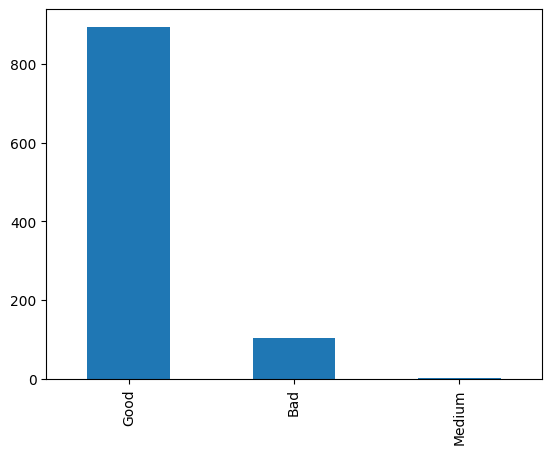

In [674]:
merged_pages["Predicted Quality"].value_counts().plot(kind="bar")


In [677]:
OUTPUT_FILE = DATA_DIR / "results_pages_classification.csv"

output_columns = ["page", "text", "Predicted Quality"]

assert (
    not OUTPUT_FILE.exists()
), f"Output file already exists: '{OUTPUT_FILE.absolute()}'"

merged_pages[output_columns].to_csv(OUTPUT_FILE)